In [250]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import timedelta
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 5]
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import warnings

## LOAD DATA

In [251]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
sample_submission = pd.read_csv('./data/sample_submission.csv')

In [252]:
train.shape

(1458644, 11)

In [253]:
test.shape

(625134, 9)

In [254]:
print([i for i in train.columns if i not in test.columns])

['dropoff_datetime', 'trip_duration']


of course, neither 'dropoff_datetime' nor 'trip_duration' should in test data.

In [255]:
len(train['id'].value_counts()) == len(train)

True

All ids are unique.

In [256]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


### check missing value

In [257]:
def check_missing_value(df):
    len0 = len(df)
    len1 = len(df.dropna())
    if len0 == len1:
        print("no missing values")
    else:
        miss = (len0-len1) 
        print("%f of the data is missing" %(miss))

In [258]:
check_missing_value(train)

no missing values


In [259]:
check_missing_value(test)

no missing values


## FEATURE ANALYSIS

## Univariate

In [260]:
train['vendor_id'].value_counts()

2    780302
1    678342
Name: vendor_id, dtype: int64

In [261]:
train['store_and_fwd_flag'].value_counts()

N    1450599
Y       8045
Name: store_and_fwd_flag, dtype: int64

In [262]:
def convert_bianry_variable(df):
    df['store_and_fwd_flag'] = 1 * (df.store_and_fwd_flag.values == 'Y')
    return df
train = convert_bianry_variable(train)
test = convert_bianry_variable(test)

both 'vendor_id' and 'store_and_fwd_flag' are binary variable

Since the evaluation metric is RMSLE, let's logtransform our target label and plot a histogram to see its distribution.

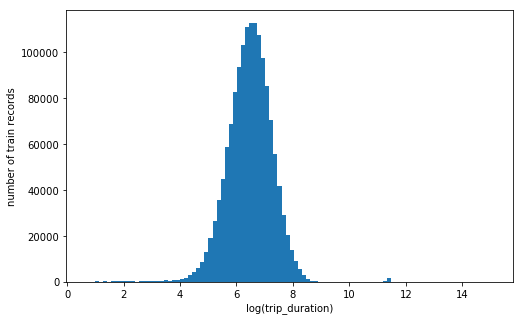

In [263]:
train['log_trip_duration'] = np.log(train['trip_duration'].values + 1)
plt.hist(train['log_trip_duration'].values, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train records')
plt.show()

In [264]:
u_limit = np.percentile(train['log_trip_duration'],99.99)
l_limit = np.percentile(train['log_trip_duration'],0.01)
train_filter = train[(train['log_trip_duration'] <= u_limit) & (train['log_trip_duration'] >= l_limit) ]
print(len(train_filter))

1458472


### datetime

In [265]:
def datetime_process(df):
    '''
    convert datetime in string format to datetime object
    '''
    df['pickup_datetime'] = pd.to_datetime(df.pickup_datetime)
    # get date
    df.loc[:, 'pickup_date'] = df['pickup_datetime'].dt.date
    df.loc[:, 'pickup_month'] = df['pickup_datetime'].dt.month
    df.loc[:, 'pickup_weekday'] = df['pickup_datetime'].dt.weekday
    df.loc[:, 'pickup_weekofyear'] = df['pickup_datetime'].dt.weekofyear
    # hour of the day
    df.loc[:, 'pickup_hour'] = df['pickup_datetime'].dt.hour
    # minute 
#     df.loc[:, 'pickup_minute'] = df['pickup_datetime'].dt.minute
    # 'pickup_dt' - duration to the minimum pickup_datetime in train
#     df.loc[:, 'pickup_dt'] = (df['pickup_datetime'] - df['pickup_datetime'].min()).dt.total_seconds()
    # hour from the begining of a week
#     df.loc[:, 'pickup_week_hour'] = df['pickup_weekday'] * 24 + df['pickup_hour']
    return df

In [266]:
train = datetime_process(train)
test = datetime_process(test)

## Bivariate

In [267]:
def get_all_stats(df,column1,column2):
    temp = df.groupby([column1])[[column2]].agg(['size','mean','median','var','std']).reset_index()
    temp = temp.round(3)
    temp.columns = [column1,'size','mean','median','var','std']
    temp = temp.set_index(column1)
    return temp

In [268]:
train_date = get_all_stats(train,'pickup_date','log_trip_duration')
train_weekday = get_all_stats(train,'pickup_weekday','log_trip_duration')
train_hour = get_all_stats(train,'pickup_hour','log_trip_duration')

In [269]:
train_date.describe()

,size,mean,median,var,std
count,182.000000,182.000000,182.000000,182.000000,182.000000
mean,8014.527473,6.465203,6.496967,0.627571,0.791797
std,925.767089,0.079468,0.082197,0.039865,0.025162
min,1648.000000,6.262000,6.280000,0.526000,0.725000
25%,7620.500000,6.407750,6.439000,0.603000,0.776250
50%,8091.000000,6.462500,6.496000,0.627000,0.792000
75%,8535.000000,6.521000,6.557000,0.650750,0.807000
max,9796.000000,6.688000,6.715000,0.722000,0.850000


In [270]:
train_date.sort_values("size")

,size,mean,median,var,std
pickup_date,,,,,
2016-01-23,1648,6.456,6.492,0.681,0.825
2016-01-24,3383,6.395,6.418,0.551,0.742
2016-05-30,5570,6.321,6.333,0.645,0.803
2016-01-25,6084,6.655,6.691,0.707,0.841
2016-01-03,6353,6.318,6.342,0.645,0.803
2016-05-29,6372,6.371,6.400,0.620,0.788
2016-01-02,6512,6.321,6.366,0.629,0.793
2016-01-04,6725,6.311,6.315,0.631,0.794
2016-06-20,6910,6.461,6.481,0.667,0.817


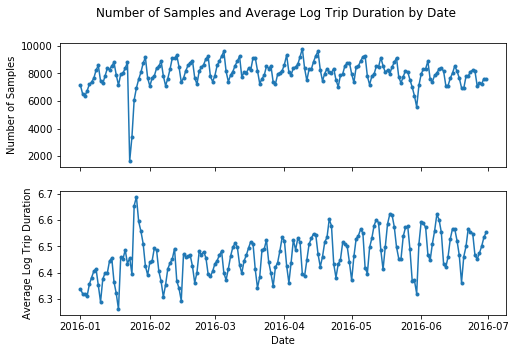

In [271]:
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=False)
ax[0].plot(train_date[["size"]],".-")
fig.suptitle("Number of Samples and Average Log Trip Duration by Date")
ax[0].set_ylabel('Number of Samples')

ax[1].plot(train_date[["mean"]],".-")
ax[1].set_ylabel('Average Log Trip Duration')
ax[1].set_xlabel('Date')

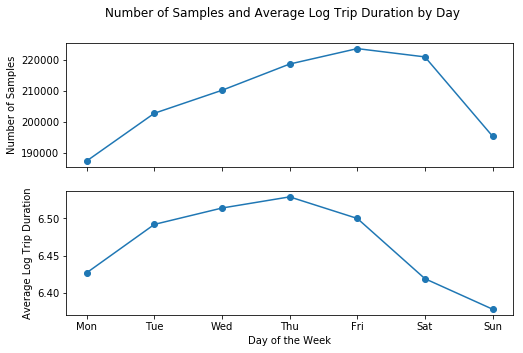

In [272]:
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=False)
ax[0].plot(train_weekday[["size"]],"o-")
fig.suptitle("Number of Samples and Average Log Trip Duration by Day")
ax[0].set_ylabel('Number of Samples')

ax[1].plot(train_weekday[["mean"]],"o-")
ax[1].set_ylabel('Average Log Trip Duration')
ax[1].set_xticklabels(["","Mon","Tue","Wed","Thu","Fri","Sat","Sun"])
ax[1].set_xlabel('Day of the Week')

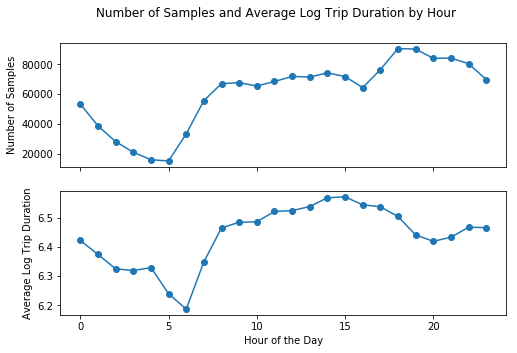

In [273]:
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=False)
ax[0].plot(train_hour[["size"]],"o-")
fig.suptitle("Number of Samples and Average Log Trip Duration by Hour")
ax[0].set_ylabel('Number of Samples')

ax[1].plot(train_hour[["mean"]],"o-")
ax[1].set_ylabel('Average Log Trip Duration')
ax[1].set_xlabel('Hour of the Day')

Morning rush hour is around 7:00 am. Trip volume largely increased after 4 pm and peaked around 6pm. 

### number of passengers and trip duration

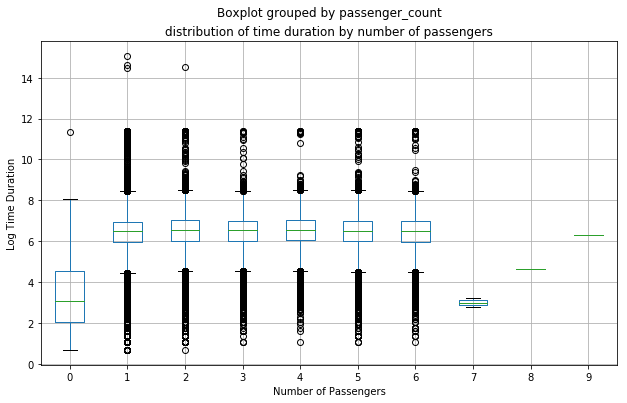

In [274]:
pplt = train[["passenger_count","log_trip_duration"]].boxplot( by="passenger_count", figsize = (10,6))
pplt.set_xlabel("Number of Passengers")
pplt.set_ylabel("Log Time Duration")
pplt.set_title("distribution of time duration by number of passengers")

In [275]:
train.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'log_trip_duration', 'pickup_date', 'pickup_month',
       'pickup_weekday', 'pickup_weekofyear', 'pickup_hour'],
      dtype='object')

### vendors and trip duration

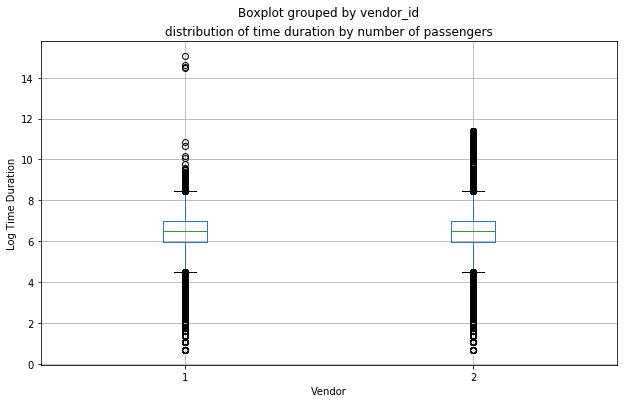

In [276]:
pplt = train[["vendor_id","log_trip_duration"]].boxplot( by="vendor_id", figsize = (10,6))
pplt.set_xlabel("Vendor")
pplt.set_ylabel("Log Time Duration")
pplt.set_title("distribution of time duration by number of passengers")

### distance and trip duration

According to many data analysis on kaggle, the distance (km) between pickup and dropoff points is a significant feature impacting trip duration. Let's calcute the distance and investigate its patterns.

In [277]:
def haversine_array(lat1, lng1, lat2, lng2):
    # the unit is in km
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371 
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

In [278]:
def get_distance(df):
    df.loc[:, 'distance_haversine'] = haversine_array(df['pickup_latitude'].values, \
                                                      df['pickup_longitude'].values, \
                                                      df['dropoff_latitude'].values, \
                                                      df['dropoff_longitude'].values)
    
    return df

train = get_distance(train)
test = get_distance(test)

In [279]:
train_filter = train[train.trip_duration < 100000]

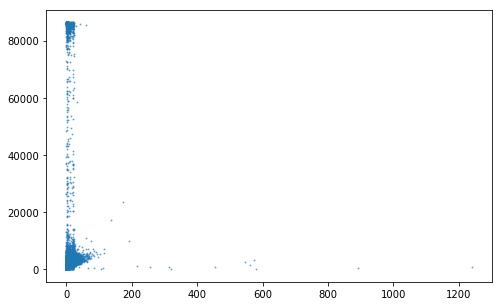

In [280]:
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train_filter.distance_haversine, train_filter.trip_duration, s=1, alpha=0.5)

### speed

In [281]:
train.loc[:, 'avg_speed_h'] = 1000 * train['distance_haversine'] / train['trip_duration']

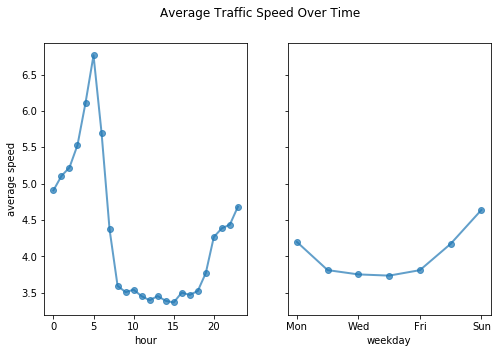

In [282]:
fig, ax = plt.subplots(ncols=2, sharey=True)
ax[0].plot(train.groupby('pickup_hour').mean()['avg_speed_h'], 'o-', lw=2, alpha=0.7)
ax[1].plot(train.groupby('pickup_weekday').mean()['avg_speed_h'], 'o-', lw=2, alpha=0.7)
ax[0].set_xlabel('hour')
ax[0].set_ylabel('average speed')

ax[1].set_xlabel('weekday')
ax[1].set_xticklabels(["","Mon","Wed","Fri","Sun"])
fig.suptitle('Average Traffic Speed Over Time')
plt.show()

### distance from external dataset

In [283]:
# add 3 more features
fr1 = pd.read_csv('./data/fastest_routes_train_part_1.csv', usecols=['id', 'total_distance', 'total_travel_time',  'number_of_steps'])
fr2 = pd.read_csv('./data/fastest_routes_train_part_2.csv', usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])
test_street_info = pd.read_csv('./data/fastest_routes_test.csv',
                               usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])
train_street_info = pd.concat((fr1, fr2))
train = train.merge(train_street_info, how='left', on='id')
test = test.merge(test_street_info, how='left', on='id')
train_street_info.head()

,id,total_distance,total_travel_time,number_of_steps
0,id2875421,2009.1,164.9,5
1,id2377394,2513.2,332.0,6
2,id3504673,1779.4,235.8,4
3,id2181028,1614.9,140.1,5
4,id0801584,1393.5,189.4,5


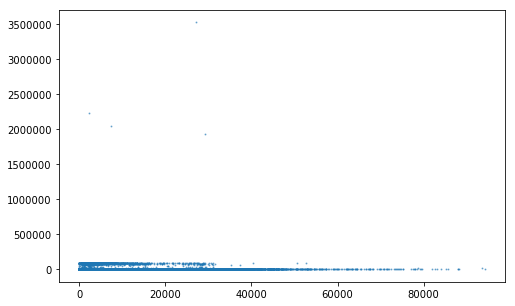

In [284]:
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train.total_distance, train.trip_duration, s=1, alpha=0.5)

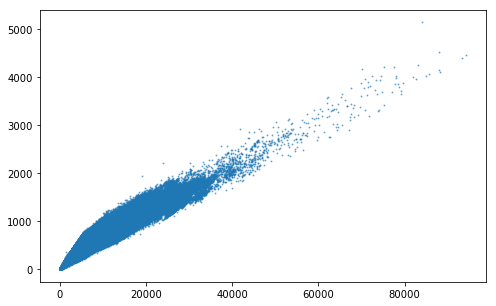

In [285]:
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train.total_distance, train.total_travel_time, s=1, alpha=0.5)

## COVERAGE BETWEEN TRAIN AND TEST

### time

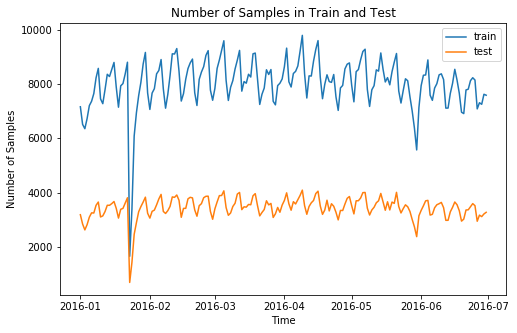

In [286]:
plt.plot(train.groupby('pickup_date')[['id']].count(), label='train')
plt.plot(test.groupby('pickup_date')[['id']].count(), label='test')
plt.title('Number of Samples in Train and Test')
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('Number of Samples')
plt.show()

### geolocation coverage

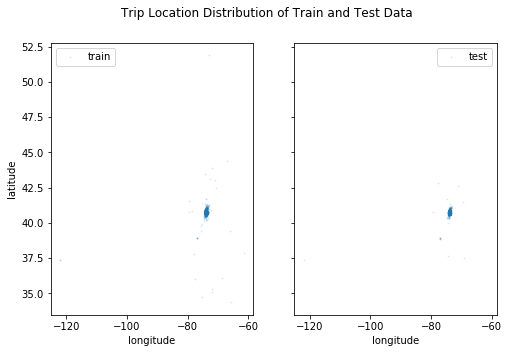

In [287]:
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
ax[0].scatter(train['pickup_longitude'].values, train['pickup_latitude'].values,
              s=1, label='train', alpha=0.1)
ax[1].scatter(test['pickup_longitude'].values, test['pickup_latitude'].values,
              s=1, label='test', alpha=0.1)
fig.suptitle('Trip Location Distribution of Train and Test Data')
ax[0].legend(loc=0)
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('longitude')
ax[1].legend(loc=0)
plt.show()

Let's zoom in to the city and see the difference.

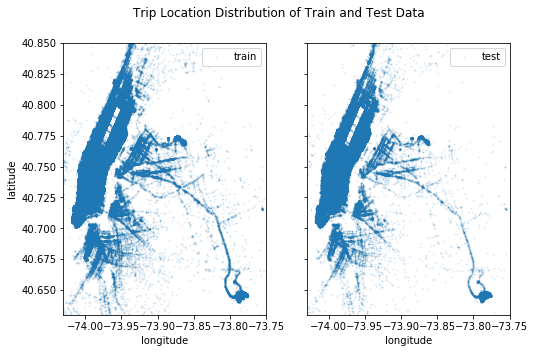

In [288]:
long_lim = (-74.03, -73.75)
lat_lim = (40.63, 40.85)
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
ax[0].scatter(train['pickup_longitude'].values, train['pickup_latitude'].values,
              s=1, label='train', alpha=0.1)
ax[1].scatter(test['pickup_longitude'].values, test['pickup_latitude'].values,
              s=1, label='test', alpha=0.1)
fig.suptitle('Trip Location Distribution of Train and Test Data')
ax[0].legend(loc=0)
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('longitude')
ax[1].legend(loc=0)
plt.xlim(long_lim)
plt.ylim(lat_lim)
plt.show()

It seems like train and test data are completely overlapped in terms of time and geolocation distribution.

# MODELING

In [289]:
train.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'log_trip_duration', 'pickup_date', 'pickup_month',
       'pickup_weekday', 'pickup_weekofyear', 'pickup_hour',
       'distance_haversine', 'avg_speed_h', 'total_distance',
       'total_travel_time', 'number_of_steps'],
      dtype='object')

In [290]:
np.setdiff1d(train.columns, test.columns)

array(['avg_speed_h', 'dropoff_datetime', 'log_trip_duration',
       'trip_duration'], dtype=object)

In [291]:
features = [i for i in train.columns if i not in ['avg_speed_h', 'dropoff_datetime', 'log_trip_duration',\
                                                  'trip_duration', 'id', 'pickup_datetime', 'dropoff_datetime',\
                                                  'distance_haversine',\
                                                 'trip_duration', 'log_trip_duration', 'trip_duration','pickup_date']]

In [292]:
features

['vendor_id',
 'passenger_count',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'store_and_fwd_flag',
 'pickup_month',
 'pickup_weekday',
 'pickup_weekofyear',
 'pickup_hour',
 'total_distance',
 'total_travel_time',
 'number_of_steps']

In [293]:
len(features)

14

In [294]:
train_filter = train.dropna()
X = train_filter[features].values
y = np.log(train_filter['trip_duration'].values + 1)
Xtr, Xv, ytr, yv = train_test_split(X, y, test_size=0.2, random_state=1987)
Xtst = test[features].values

### decision tree

In [295]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

In [296]:
param_grid = {'max_depth': np.arange(3, 10)}
tree = GridSearchCV(DecisionTreeRegressor(), param_grid)
tree.fit(Xtr, ytr)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': array([3, 4, 5, 6, 7, 8, 9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [297]:
tree.best_params_

{'max_depth': 9}

In [298]:
y_pred = tree.predict(Xv)
rmsle = np.sqrt(sum(np.square(y_pred - yv)) / len(y_pred))
print("rmsle of decision tree is: %.3f"%rmsle)

rmsle of decision tree is: 0.437


In [299]:
# submission
ytest = tree.predict(Xtst)
test['trip_duration'] = np.exp(ytest) - 1
test[['id', 'trip_duration']].to_csv('dt_submission.csv.gz', index=False, compression='gzip')

### Gradient Boosting tree

In [300]:
dtrain = xgb.DMatrix(Xtr, label=ytr)
dvalid = xgb.DMatrix(Xv, label=yv)
dtest = xgb.DMatrix(Xtst)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

xgb_pars = {'min_child_weight': 50, 'eta': 0.3, 'colsample_bytree': 0.3, 'max_depth': 10,
            'subsample': 0.8, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}

In [301]:
model = xgb.train(xgb_pars, dtrain, 60, watchlist, early_stopping_rounds=50,
                  maximize=False, verbose_eval=10)

[0]	train-rmse:4.2281	valid-rmse:4.22878
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.438642	valid-rmse:0.445448
[20]	train-rmse:0.406749	valid-rmse:0.417702
[30]	train-rmse:0.393827	valid-rmse:0.408836
[40]	train-rmse:0.38765	valid-rmse:0.405391
[50]	train-rmse:0.384579	valid-rmse:0.404152


In [302]:
y_pred = model.predict(dvalid)
rmsle = np.sqrt(sum(np.square(y_pred - yv)) / len(y_pred))
print("rmsle of gbt is: %.3f"%rmsle)

rmsle of gbt is: 0.404


In [303]:
# for submission
ytest = model.predict(dtest)
test['trip_duration'] = np.exp(ytest) - 1
test[['id', 'trip_duration']].to_csv('xgb_submission.csv.gz', index=False, compression='gzip')

In [304]:
fs = ['f%i' % i for i in range(len(features))]
name = dict(zip(fs, features))

feature_importance_dict = model.get_fscore()
f_i = pd.DataFrame({'feature': list(feature_importance_dict.keys()), \
                    'importance': list(feature_importance_dict.values())})
f_i["feature"] = f_i["feature"].apply(lambda x: name[x])

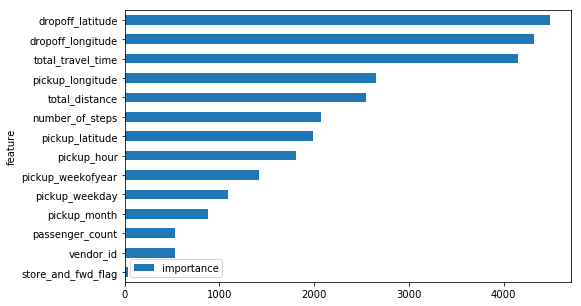

In [305]:
f_i = f_i.sort_values("importance")
f_i.set_index("feature").plot(kind='barh')